In [23]:
import pandas as pd
from scipy import stats
import random
import math
import numpy as np

In [24]:
def split_data(df : pd.DataFrame, seed : int, train_frac : float = 0.5):

    separator_index = math.floor(df.shape[0]*train_frac)

    sample_df = df.sample(frac=1.0, random_state=seed, ignore_index=True)
    train_df = sample_df.iloc[0:separator_index]
    test_df = sample_df.iloc[separator_index:].reset_index(drop=True)
    
    return(train_df, test_df)

def split_data_to_fold(df : pd.DataFrame, seed : int, folds : int):

    data_per_fold = df.shape[0] // folds
    remainder =  df.shape[0] % folds

    size_list = [data_per_fold]*folds
    for i in range(remainder):
        size_list[i] += 1

    sample_df = df.sample(frac=1.0, random_state=seed, ignore_index=True)
    dfs = []
    
    start_index = 0
    for i in range(len(size_list)):
        
        dfs.append(sample_df.iloc[start_index : start_index + size_list[i]] )
        start_index += size_list[i]

    return dfs

def train(df):
    slope, intercept, r, p, se = stats.linregress(df["Height"], df["Weight"])
    return slope,intercept,r

def cross_validation(fold_data):
    metric_dict = {}
    RMSE = []
    MAE = []
    r_list = []
    RAE = []
    RRSE = []
    for i in range(len(fold_data)):
        test_df = fold_data[i]
        test_df.reset_index(inplace=True)
        train_df = list(fold_data)
        train_df.pop(i)
        slope,intercept,r = train(pd.concat(train_df, ignore_index=True))
        RMSE.append(CalculateRMSE(test_df["Height"],test_df["Weight"],intercept,slope))
        MAE.append(CalculateMAE(test_df["Height"], test_df["Weight"], intercept, slope))
        RAE.append(CalculateRAE(test_df["Height"], test_df["Weight"], intercept, slope))
        RRSE.append(CalculateRRSE(test_df["Height"], test_df["Weight"], intercept, slope))
        r_list.append(r)
    metric_dict['RMSE'] = np.average(RMSE)
    metric_dict['MAE'] = np.average(MAE)
    metric_dict['r'] = np.average(r_list)
    metric_dict['RAE'] = np.average(RAE)
    metric_dict['RRSE'] = np.average(RRSE)
    return metric_dict

def holdout(df : pd.DataFrame, seed_amt : int, train_frac : float):
    avg_rmse = 0
    avg_mae = 0
    avg_r = 0
    avg_rae = 0
    avg_rrse = 0

    rmse_list, mae_list, r_list, rae_list, rrse_list = [], [], [], [], []

    for i in range(seed_amt):
        train_df, test_df = split_data(df, i, train_frac)
        slope, intercept, r, p, se = stats.linregress(train_df["Height"], train_df["Weight"])

        rmse = CalculateMSE(test_df["Height"], test_df["Weight"], intercept, slope)**(1/2)
        mae = CalculateMAE(test_df["Height"], test_df["Weight"], intercept, slope)
        rae = CalculateRAE(test_df["Height"], test_df["Weight"], intercept, slope)
        rrse = CalculateRRSE(test_df["Height"], test_df["Weight"], intercept, slope)

        rmse_list.append(rmse)
        mae_list.append(mae)
        r_list.append(r)
        rae_list.append(rae)
        rrse_list.append(rrse)

        avg_rmse += rmse
        avg_mae += mae
        avg_r += r
        avg_rae += rae
        avg_rrse += rrse

    return {"RMSE" : avg_rmse / seed_amt, "MAE" : avg_mae / seed_amt, 
            "r" : avg_r / seed_amt, "RAE" : avg_rae / seed_amt, 
            "RRSE" : avg_rrse / seed_amt, "STD" : np.std(rmse_list)}

def CalculateMSE(x_positions, y_positions, w0, w1):
    n = len(x_positions)
    MSE = 0
    for i in range(0, n):
        MSE += (w0 + w1*x_positions[i] - y_positions[i]) ** 2
    MSE *= 1/(n)
    return MSE

def CalculateRMSE(x_positions, y_positions, w0, w1):
    return CalculateMSE(x_positions, y_positions, w0, w1) ** (1/2)

def CalculateMAE(x_positions, y_positions, w0, w1):
    n = len(x_positions)
    MAE = 0
    for i in range(0, n):
        MAE += abs(w0 + w1*x_positions[i] - y_positions[i])
    MAE *= 1/n
    return MAE

def CalculateRAE(x_positions, y_positions, w0, w1):
    n = len(y_positions)
    y_bar = sum(y_positions) / n
    
    err_from_model = 0
    err_from_avg = 0
    for i in range(0,n):
        err_from_model += abs(y_positions[i] - (w0 + w1*x_positions[i]))
        err_from_avg += abs(y_positions[i] - y_bar)
    return err_from_model / err_from_avg

def CalculateRRSE(x_positions, y_positions, w0, w1):
    n = len(y_positions)
    y_bar = sum(y_positions) / n
    
    err_from_model = 0
    err_from_avg = 0
    for i in range(0,n):
        err_from_model += (y_positions[i] - (w0 + w1*x_positions[i]))**2
        err_from_avg += (y_positions[i] - y_bar)**2
    return (err_from_model / err_from_avg)**(1/2)



# 1. ใช้ data set ที่เรียน ทุกการทดลองให้เพิ่มจำนวนครั้งในการทดลองซ้ำให้มากกว่าใน lecture และรายละเอียดอื่นๆเพิ่มเติมที่คิดว่าจำเป็น

## การทดสอบความเที่ยงตรง (Precision) ของวิธี Holdout

In [25]:
df = pd.read_csv("data/HeightWeight20.csv")
for i in range(1, 10):
    print(f"-----------------{i*10}%-------------------")
    holdout_result = holdout(df, 100, i/10)
    print(f"Average RMSE : {holdout_result['RMSE']:.4f}")
    print(f"Standard Deviation: {holdout_result['STD']:.4f}")
    print(f"Average MAE : {holdout_result['MAE']:.4f}")
    print(f"Average RAE : {holdout_result['RAE']:.4f}")
    print(f"Average RRSE : {holdout_result['RRSE']:.4f}")

-----------------10%-------------------
Average RMSE : 27.5366
Standard Deviation: 57.4182
Average MAE : 23.6873
Average RAE : 1.7251
Average RRSE : 1.6088
-----------------20%-------------------
Average RMSE : 9.2948
Standard Deviation: 2.5371
Average MAE : 7.9804
Average RAE : 0.5696
Average RRSE : 0.5322
-----------------30%-------------------
Average RMSE : 8.4142
Standard Deviation: 1.8084
Average MAE : 7.4068
Average RAE : 0.5295
Average RRSE : 0.4842
-----------------40%-------------------
Average RMSE : 8.1178
Standard Deviation: 1.3866
Average MAE : 7.2618
Average RAE : 0.5366
Average RRSE : 0.4811
-----------------50%-------------------
Average RMSE : 7.8889
Standard Deviation: 1.2278
Average MAE : 7.1124
Average RAE : 0.5291
Average RRSE : 0.4709
-----------------60%-------------------
Average RMSE : 7.7964
Standard Deviation: 1.1417
Average MAE : 7.1255
Average RAE : 0.5416
Average RRSE : 0.4783
-----------------70%-------------------
Average RMSE : 7.5731
Standard Deviatio

## การทดสอบความเที่ยงตรง (Precision) ของวิธี k- fold Cross-Validation

In [26]:
df = pd.read_csv("data/HeightWeight20.csv")
fold_list = [2,3,5,10]
seed_num = 20
for fold in fold_list:
    av_rmse = []
    av_mae = []
    av_rae = []
    av_rrse = []
    print(fold,"fold")
    for seed in range(seed_num):
        fold_df = split_data_to_fold(df,seed,fold)
        metrics = cross_validation(fold_df)
        av_rmse.append(metrics['RMSE'])
        av_mae.append(metrics['MAE'])
        av_rae.append(metrics['RAE'])
        av_rrse.append(metrics['RRSE'])
    print(f"Average RMSE : {np.average(av_rmse):.4f}")
    print(f"Standard Deviation: {np.std(av_rmse):.4f}")
    print(f"Average MAE : {np.average(av_mae):.4f}")
    print(f"Average RAE : {np.average(av_rae):.4f}")
    print(f"Average RRSE : {np.average(av_rrse):.4f}", "\n")

2 fold
Average RMSE : 7.8784
Standard Deviation: 0.9597
Average MAE : 7.1081
Average RAE : 0.5187
Average RRSE : 0.4666 

3 fold
Average RMSE : 7.5800
Standard Deviation: 0.6298
Average MAE : 6.9598
Average RAE : 0.5319
Average RRSE : 0.4799 

5 fold
Average RMSE : 7.3804
Standard Deviation: 0.3220
Average MAE : 6.9042
Average RAE : 0.6285
Average RRSE : 0.5804 

10 fold
Average RMSE : 7.1651
Standard Deviation: 0.1942
Average MAE : 6.8679
Average RAE : 1.6757
Average RRSE : 1.7356 



## การทดสอบความเที่ยงตรง (Precision) และความแม่นยํา (Accuracy) เมื่อจํานวนข้อมูลมากขึ้น

### Holdout

In [27]:
df = pd.read_csv("data/HeightWeight100.csv")
for i in range(1, 10):
    print(f"-----------------{i*10}%-------------------")
    holdout_result = holdout(df, 100, i/10)
    print(f"Average RMSE : {holdout_result['RMSE']:.4f}")
    print(f"Standard Deviation: {holdout_result['STD']:.4f}")
    print(f"Average MAE : {holdout_result['MAE']:.4f}")
    print(f"Average RAE : {holdout_result['RAE']:.4f}")
    print(f"Average RRSE : {holdout_result['RRSE']:.4f}")

-----------------10%-------------------
Average RMSE : 6.3293
Standard Deviation: 0.5321
Average MAE : 5.0733
Average RAE : 0.4204
Average RRSE : 0.4347
-----------------20%-------------------
Average RMSE : 6.0292
Standard Deviation: 0.3498
Average MAE : 4.8210
Average RAE : 0.4005
Average RRSE : 0.4152
-----------------30%-------------------
Average RMSE : 5.9283
Standard Deviation: 0.3419
Average MAE : 4.7346
Average RAE : 0.3942
Average RRSE : 0.4083
-----------------40%-------------------
Average RMSE : 5.8755
Standard Deviation: 0.3515
Average MAE : 4.6947
Average RAE : 0.3926
Average RRSE : 0.4063
-----------------50%-------------------
Average RMSE : 5.8319
Standard Deviation: 0.4027
Average MAE : 4.6482
Average RAE : 0.3905
Average RRSE : 0.4047
-----------------60%-------------------
Average RMSE : 5.8103
Standard Deviation: 0.4989
Average MAE : 4.6349
Average RAE : 0.3913
Average RRSE : 0.4057
-----------------70%-------------------
Average RMSE : 5.8208
Standard Deviation: 

### K-fold Cross validation

In [28]:
df = pd.read_csv("data/HeightWeight100.csv")
fold_list = [2,3,5,10]
seed_num = 20
for fold in fold_list:
    av_rmse = []
    av_mae = []
    av_rae = []
    av_rrse = []
    print(fold,"fold")
    for seed in range(seed_num):
        fold_df = split_data_to_fold(df,seed,fold)
        metrics = cross_validation(fold_df)
        av_rmse.append(metrics['RMSE'])
        av_mae.append(metrics['MAE'])
        av_rae.append(metrics['RAE'])
        av_rrse.append(metrics['RRSE'])
    print(f"Average RMSE : {np.average(av_rmse):.4f}")
    print(f"Standard Deviation: {np.std(av_rmse):.4f}")
    print(f"Average MAE : {np.average(av_mae):.4f}")
    print(f"Average RAE : {np.average(av_rae):.4f}")
    print(f"Average RRSE : {np.average(av_rrse):.4f}", "\n")

2 fold
Average RMSE : 5.9201
Standard Deviation: 0.1514
Average MAE : 4.7465
Average RAE : 0.3949
Average RRSE : 0.4089 

3 fold
Average RMSE : 5.8506
Standard Deviation: 0.1123
Average MAE : 4.6757
Average RAE : 0.3937
Average RRSE : 0.4086 

5 fold
Average RMSE : 5.8027
Standard Deviation: 0.0501
Average MAE : 4.6564
Average RAE : 0.3999
Average RRSE : 0.4130 

10 fold
Average RMSE : 5.7400
Standard Deviation: 0.0473
Average MAE : 4.6492
Average RAE : 0.4223
Average RRSE : 0.4338 



## การทดสอบความแม่นยํา (Accuracy) ของเครื่องมือวัดประสิทธิภาพของแบบจําลอง

### Training

In [35]:
df = pd.read_csv("data/HeightWeight.csv")
slope,intercept = train(df)[0:2]
print("Reference:",round(CalculateRMSE(df["Height"],df["Weight"],intercept,slope),4))

Reference: 5.5422


### Holdout

In [31]:
full_df = pd.read_csv("data/HeightWeight.csv")

for i in range(1, 10):
    sum_rmse = 0
    sum_std = 0
    sum_mae = 0
    sum_r = 0
    sum_rae = 0
    sum_rrse = 0
    print(f"-----------------{i*10}%-------------------")
    for seed in range(100):
        sample_20_df = full_df.sample(n=20, random_state=seed, ignore_index=True)
        holdout_result = holdout(sample_20_df, 100, i/10)
        sum_rmse += holdout_result["RMSE"]
        sum_std += holdout_result["STD"]
        sum_mae += holdout_result["MAE"]
        sum_r += holdout_result["r"]
        sum_rae += holdout_result["RAE"]
        sum_rrse += holdout_result["RRSE"]
    avg_rmse = sum_rmse / 100
    avg_std = sum_std / 100
    avg_mae = sum_mae / 100
    avg_r = sum_r / 100
    avg_rae = sum_rae / 100
    avg_rrse = sum_rrse / 100
    print(f"Average RMSE : {avg_rmse:.4f}")
    print(f"Standard Deviation: {avg_std:.4f}")
    print(f"Average MAE : {avg_mae:.4f}")
    print(f"Average RAE : {avg_rae:.4f}")
    print(f"Average RRSE : {avg_rrse:.4f}")

-----------------10%-------------------
Average RMSE : 61.8519
Standard Deviation: 375.0051
Average MAE : 51.0554
Average RAE : 4.5010
Average RRSE : 4.6062
-----------------20%-------------------
Average RMSE : 7.7745
Standard Deviation: 3.4092
Average MAE : 6.3888
Average RAE : 0.5496
Average RRSE : 0.5653
-----------------30%-------------------
Average RMSE : 6.6320
Standard Deviation: 1.5479
Average MAE : 5.4435
Average RAE : 0.4742
Average RRSE : 0.4880
-----------------40%-------------------
Average RMSE : 6.2348
Standard Deviation: 1.1339
Average MAE : 5.1183
Average RAE : 0.4518
Average RRSE : 0.4649
-----------------50%-------------------
Average RMSE : 6.0118
Standard Deviation: 1.0651
Average MAE : 4.9445
Average RAE : 0.4473
Average RRSE : 0.4592
-----------------60%-------------------
Average RMSE : 5.8405
Standard Deviation: 1.1548
Average MAE : 4.8252
Average RAE : 0.4524
Average RRSE : 0.4624
-----------------70%-------------------
Average RMSE : 5.7076
Standard Deviati

### K-fold Cross validation

In [ ]:
full_df = pd.read_csv("data/HeightWeight.csv")
fold_list = [2,3,5,10]
seed_num = 100
for fold in fold_list:
    av_rmse = []
    print(fold,"fold")
    for seed in range(seed_num):
        sample_20_df = full_df.sample(n=20, random_state=seed, ignore_index=True)
        for seed2 in range(seed_num):
            fold_df = split_data_to_fold(sample_20_df,seed2,fold)
            metrics = cross_validation(fold_df)
            av_rmse.append(metrics['RMSE'])
            av_mae.append(metrics['MAE'])
            av_rae.append(metrics['RAE'])
            av_rrse.append(metrics['RRSE'])
    print(f"Average RMSE : {np.average(av_rmse):.4f}")
    print(f"Standard Deviation: {np.std(av_rmse):.4f}")
    print(f"Average MAE : {np.average(av_mae):.4f}")
    print(f"Average RAE : {np.average(av_rae):.4f}")
    print(f"Average RRSE : {np.average(av_rrse):.4f}", "\n")

2 fold
Average RMSE : 6.0234
Standard Deviation: 1.1814
Average MAE : 4.9530
Average RAE : 0.4479
Average RRSE : 0.4596 

3 fold
Average RMSE : 5.7698
Standard Deviation: 0.9802
Average MAE : 4.8739
Average RAE : 0.4568
Average RRSE : 0.4667 

5 fold
Average RMSE : 5.5752
Standard Deviation: 0.9004
Average MAE : 4.8296
Average RAE : 0.4901
Average RRSE : 0.5000 

10 fold
Average RMSE : 5.2218
Standard Deviation: 0.8225
Average MAE : 4.7987
Average RAE : 1.0438
Average RRSE : 1.1229 



## การทดลองเพิ่มเติม : ใช้ข้อมูลทั้งหมด 10,000 ตัวอย่างสร้างแบบจําลอง Linear Regression โดยเลือก Test options เป็น Use training set, Holdout และ Cross-validation สังเกตค่า RMSE และอภิปรายผล


### Training

In [34]:
df = pd.read_csv("data/HeightWeight.csv")
slope,intercept = train(df)[0:2]
print("Reference:",round(CalculateRMSE(df["Height"],df["Weight"],intercept,slope),4))

Reference: 5.5422


### Holdout

In [32]:
df = pd.read_csv("data/HeightWeight.csv")
for i in range(1, 10):
    print(f"-----------------{i*10}%-------------------")
    holdout_result = holdout(df, 100, i/10)
    print(f"Average RMSE : {holdout_result['RMSE']:.4f}")
    print(f"Standard Deviation: {holdout_result['STD']:.4f}")
    print(f"Average MAE : {holdout_result['MAE']:.4f}")
    #print(f"Average Correlation coefficient : {holdout_result['r']:.4f}")
    print(f"Average RAE : {holdout_result['RAE']:.4f}")
    print(f"Average RRSE : {holdout_result['RRSE']:.4f}")

-----------------10%-------------------
Average RMSE : 5.5486
Standard Deviation: 0.0120
Average MAE : 4.4263
Average RAE : 0.3580
Average RRSE : 0.3810
-----------------20%-------------------
Average RMSE : 5.5460
Standard Deviation: 0.0194
Average MAE : 4.4239
Average RAE : 0.3579
Average RRSE : 0.3809
-----------------30%-------------------
Average RMSE : 5.5452
Standard Deviation: 0.0271
Average MAE : 4.4238
Average RAE : 0.3579
Average RRSE : 0.3809
-----------------40%-------------------
Average RMSE : 5.5484
Standard Deviation: 0.0381
Average MAE : 4.4263
Average RAE : 0.3579
Average RRSE : 0.3808
-----------------50%-------------------
Average RMSE : 5.5458
Standard Deviation: 0.0459
Average MAE : 4.4247
Average RAE : 0.3578
Average RRSE : 0.3807
-----------------60%-------------------
Average RMSE : 5.5413
Standard Deviation: 0.0528
Average MAE : 4.4213
Average RAE : 0.3571
Average RRSE : 0.3800
-----------------70%-------------------
Average RMSE : 5.5404
Standard Deviation: 

### K-fold Cross validation

In [33]:
df = pd.read_csv("data/HeightWeight.csv")
fold_list = [2,3,5,10]
seed_num = 100
for fold in fold_list:
    av_rmse = []
    av_mae = []
    av_rae = []
    av_rrse = []
    print(fold,"fold")
    for seed in range(seed_num):
        fold_df = split_data_to_fold(df,seed,fold)
        metrics = cross_validation(fold_df)
        av_rmse.append(metrics['RMSE'])
        av_mae.append(metrics['MAE'])
        av_rae.append(metrics['RAE'])
        av_rrse.append(metrics['RRSE'])
    print(f"Average RMSE : {np.average(av_rmse):.4f}")
    print(f"Standard Deviation: {np.std(av_rmse):.4f}")
    print(f"Average MAE : {np.average(av_mae):.4f}")
    print(f"Average RAE : {np.average(av_rae):.4f}")
    print(f"Average RRSE : {np.average(av_rrse):.4f}", "\n")

2 fold
Average RMSE : 5.5437
Standard Deviation: 0.0017
Average MAE : 4.4224
Average RAE : 0.3577
Average RRSE : 0.3807 

3 fold
Average RMSE : 5.5432
Standard Deviation: 0.0009
Average MAE : 4.4222
Average RAE : 0.3577
Average RRSE : 0.3807 

5 fold
Average RMSE : 5.5428
Standard Deviation: 0.0007
Average MAE : 4.4220
Average RAE : 0.3578
Average RRSE : 0.3807 

10 fold
Average RMSE : 5.5420
Standard Deviation: 0.0006
Average MAE : 4.4219
Average RAE : 0.3580
Average RRSE : 0.3809 



# 2. Generate Data ขึ้นมาเอง เช่น noiseless หรือ noisy ของฟังก์ชัน sin เพื่อสร้างกราฟ Expected Validation Error ตาม lecture หน้าที่ 60 

## Noiseless Sin

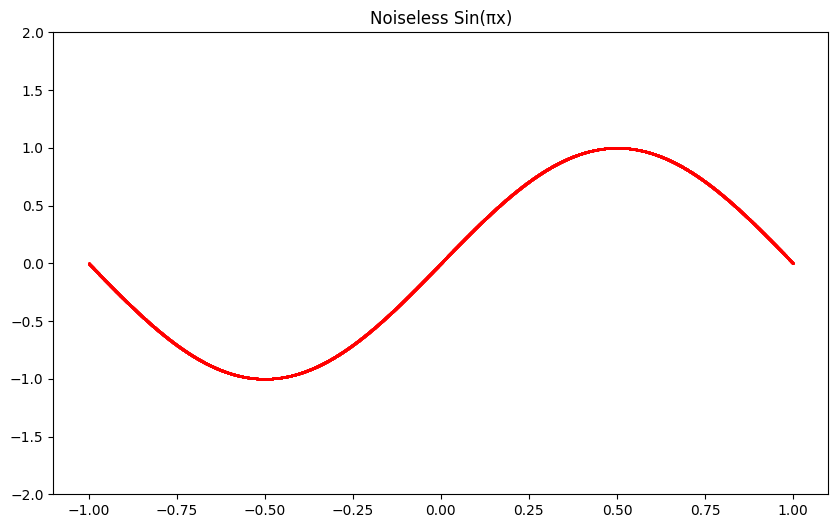

In [38]:
# x and y given as DataFrame columns
import matplotlib.pyplot as plt

df = pd.read_csv("data/sin_noiseless.csv")
plt.figure(figsize=(10, 6))
plt.ylim(-2, 2)
plt.title("Noiseless Sin(πx)")

plt.scatter(df['x'], df['y'], color='r', s=0.5)

In [40]:
full_df = pd.read_csv("data/sin_noiseless.csv")
# full_df = pd.read_csv("data/HeightWeight.csv")
seed_num = 100
max_test = 16
num_sample = 500
err_av_np = np.array([0.0]*max_test)
err_var_np = np.array([0.0]*max_test)
for j in range(num_sample):
    err_av = []
    err_var = []
    sample_20_df = full_df.sample(n=20, random_state=j, ignore_index=True)
    for k in range(1, max_test+1):
        MSE = []
        for seed in range(seed_num):
            sample_20_df = sample_20_df.sample(
                frac=1.0, random_state=seed, ignore_index=True)
            test_df = sample_20_df.iloc[0:k]
            train_df = sample_20_df.iloc[k:].reset_index(drop=True)
            slope, intercept = stats.linregress(
                train_df["x"], train_df["y"])[0:2]

            MSE.append(CalculateMSE(
                test_df["x"], test_df["y"], intercept, slope))
        err_av.append(np.average(MSE))
        err_var.append(np.var(MSE))
    err_av_np += np.array(err_av)
    err_var_np += np.array(err_var)
err_av_np /= num_sample
err_var_np /= num_sample

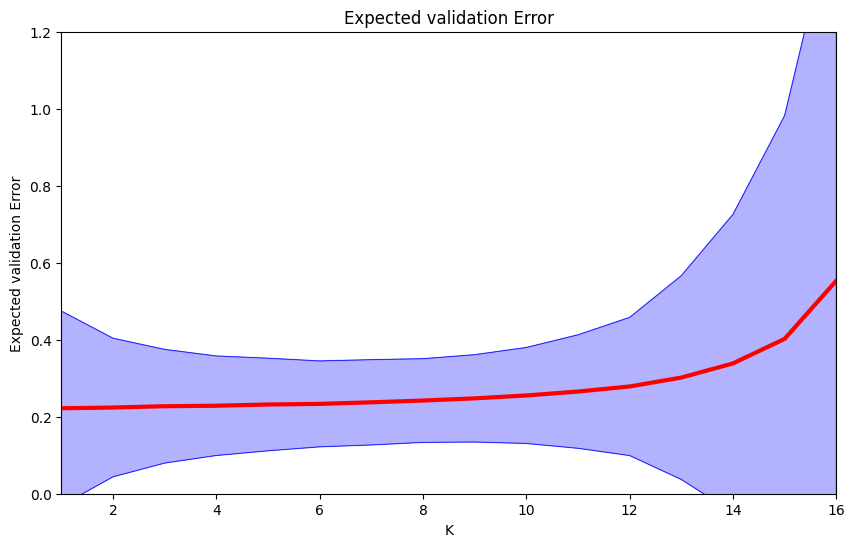

In [41]:
plt.figure(figsize=(10, 6))
plt.ylim(0, 1.2)
plt.xlim(1, 16)
plt.title("Expected validation Error")
plt.xlabel("K")
plt.ylabel("Expected validation Error")

# Sin graph
x_vals = np.array(range(1, max_test+1))
y_vals = err_av_np
plt.plot(x_vals, y_vals, '-', color='r', linewidth=3)


var1 = (err_var_np**(1/2)) + np.array(y_vals)
plt.plot(x_vals, var1, '-', color='b', linewidth=0.5)

var2 = np.array(y_vals) - (err_var_np**(1/2))
plt.plot(x_vals, var2, '-', color='b', linewidth=0.5)
plt.fill_between(x_vals, var2, var1, color='b', alpha=0.3)

## Noisy Sin

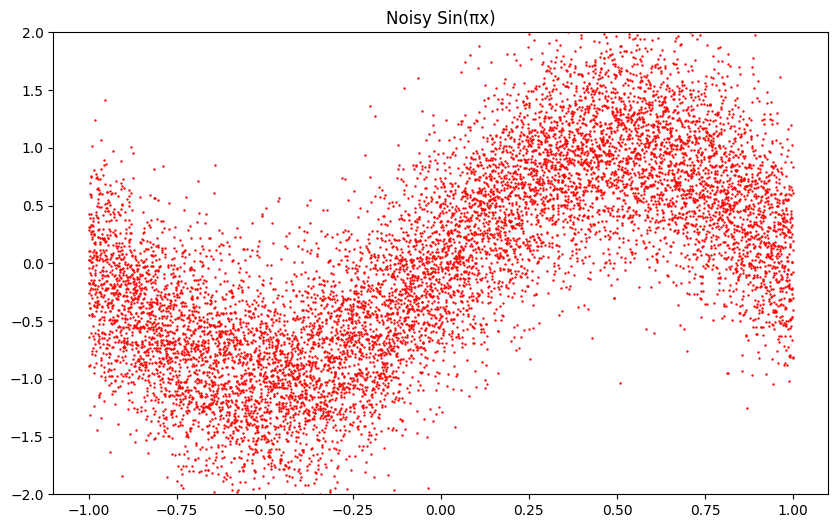

In [42]:
# x and y given as DataFrame columns
import matplotlib.pyplot as plt

df = pd.read_csv("data/sin_noisy.csv")
plt.figure(figsize=(10, 6))
plt.ylim(-2, 2)
plt.title("Noisy Sin(πx)")

plt.scatter(df['x'], df['y'], color='r', s=0.5)

In [45]:
full_df = pd.read_csv("data/sin_noisy.csv")
seed_num = 100
max_test = 16
num_sample = 500
err_av_np = np.array([0.0]*max_test)
err_var_np = np.array([0.0]*max_test)
for j in range(num_sample):
    err_av = []
    err_var = []
    sample_20_df = full_df.sample(n=20, random_state=j, ignore_index=True)
    for k in range(1, max_test+1):
        MSE = []
        for seed in range(seed_num):
            sample_20_df = sample_20_df.sample(
                frac=1.0, random_state=seed, ignore_index=True)
            test_df = sample_20_df.iloc[0:k]
            train_df = sample_20_df.iloc[k:].reset_index(drop=True)
            slope, intercept = stats.linregress(
                train_df["x"], train_df["y"])[0:2]

            MSE.append(CalculateMSE(
                test_df["x"], test_df["y"], intercept, slope))
        err_av.append(np.average(MSE))
        err_var.append(np.var(MSE))
    err_av_np += np.array(err_av)
    err_var_np += np.array(err_var)
err_av_np /= num_sample
err_var_np /= num_sample

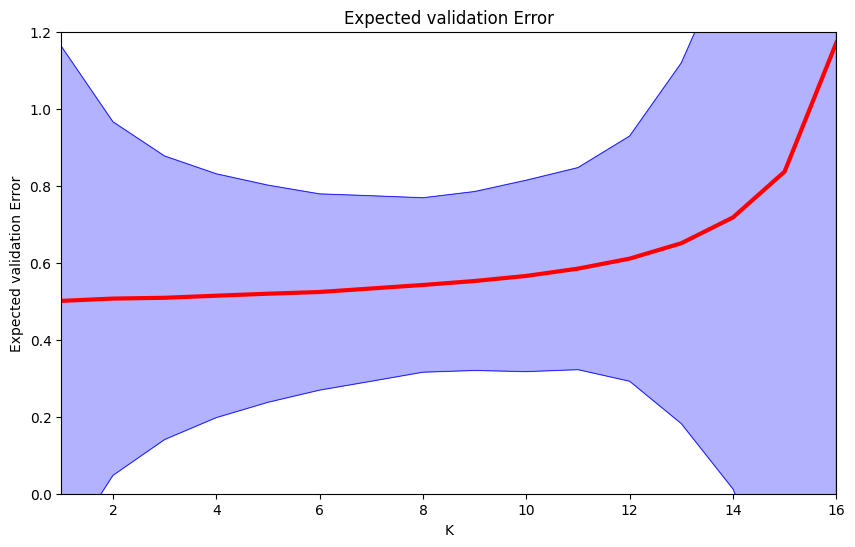

In [46]:
plt.figure(figsize=(10, 6))
plt.ylim(0, 1.2)
plt.xlim(1, 16)
plt.title("Expected validation Error")
plt.xlabel("K")
plt.ylabel("Expected validation Error")

# Sin graph
x_vals = np.array(range(1, max_test+1))
y_vals = err_av_np
plt.plot(x_vals, y_vals, '-', color='r', linewidth=3)


var1 = (err_var_np**(1/2)) + np.array(y_vals)
plt.plot(x_vals, var1, '-', color='b', linewidth=0.5)

var2 = np.array(y_vals) - (err_var_np**(1/2))
plt.plot(x_vals, var2, '-', color='b', linewidth=0.5)
plt.fill_between(x_vals, var2, var1, color='b', alpha=0.3)